<a href="https://colab.research.google.com/github/BetriuJaume/SMDS/blob/main/Copy_of_SMDS_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Property Price Forecasting
##Betriu Tort Jaume, Verona 11-02-2022

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import math
from sklearn.linear_model import LinearRegression
plt.style.use('seaborn')
from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.holtwinters import Holt
from statsmodels.tsa.holtwinters import ExponentialSmoothing

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_csv('State_house_prices_ts.csv',sep=';')

We can see that there are some states that don't have any data on some types of houses or in speciffic dates:

In [3]:
data['RegionName'].value_counts() #The maximum is 261 so we will use one of this states

Alabama               261
Missouri              261
Nevada                261
Arizona               261
NewJersey             261
NewMexico             261
NewYork               261
NorthCarolina         261
Ohio                  261
Oklahoma              261
Oregon                261
Pennsylvania          261
RhodeIsland           261
SouthCarolina         261
Tennessee             261
Texas                 261
Utah                  261
Virginia              261
Washington            261
WestVirginia          261
Wisconsin             261
Nebraska              261
NewHampshire          261
Mississippi           261
Illinois              261
Arkansas              261
California            261
Colorado              261
Connecticut           261
Delaware              261
Florida               261
Minnesota             261
Hawaii                261
Idaho                 261
Georgia               261
Indiana               261
Maine                 261
Iowa                  261
Massachusett

For example for states North Dakota and Columbia we have a lot of dates missing

#Exploration of the data
Let's explore the data simply by ploting the price of every house type on every state to get a general idea of what is happening:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


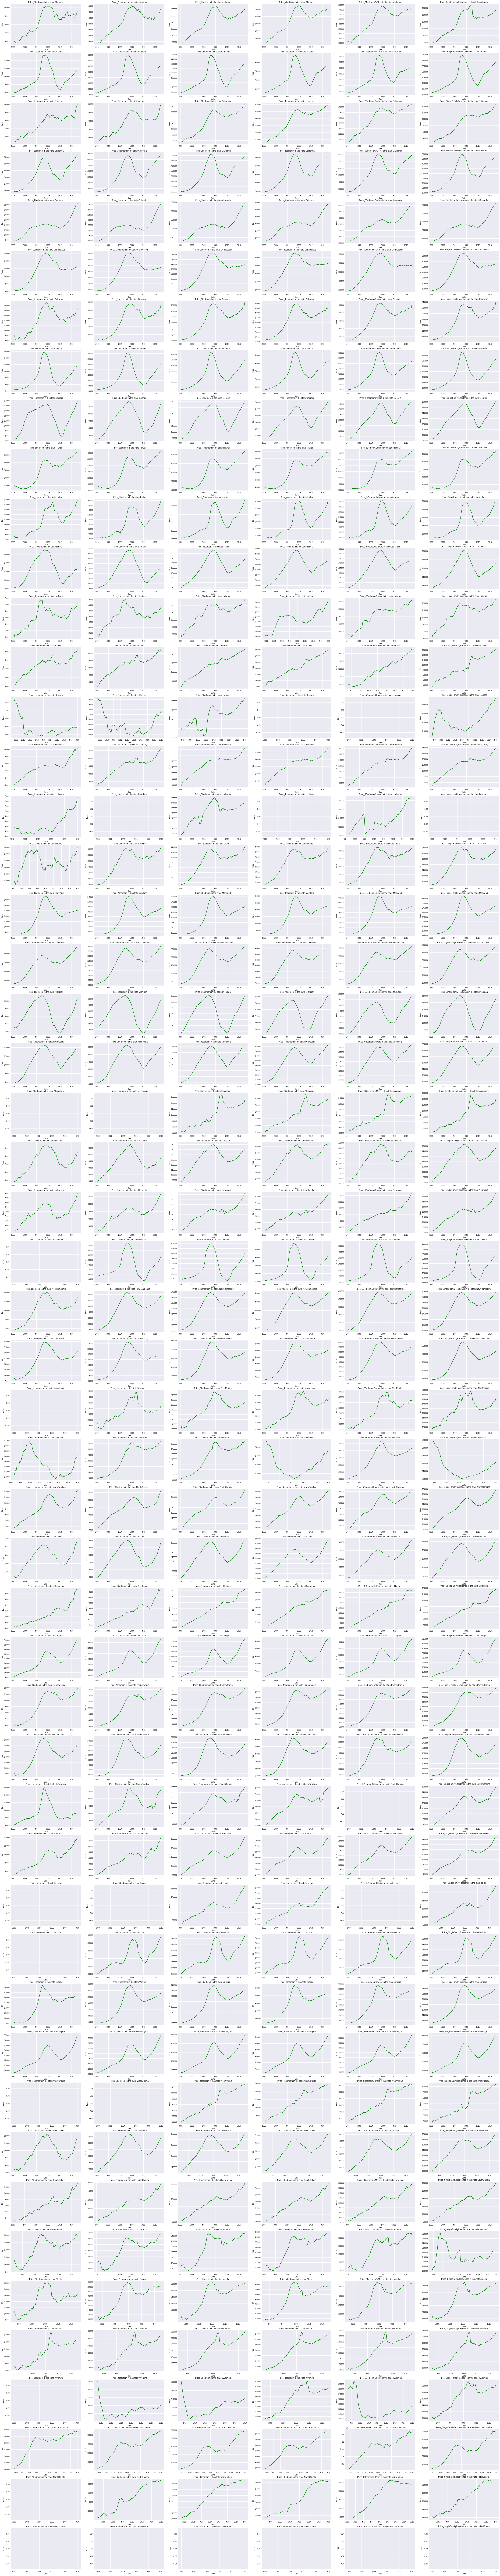

In [4]:
list_of_data_states=[]
for state in data['RegionName'].unique()[1:]:
  data_state=data[data['RegionName']==state]
  data_state['Date']=pd.to_datetime(data_state['Date'])
  data_state=data_state.set_index('Date')
  data_state=data_state.drop('RegionName',axis=1)
  list_of_data_states.append(data_state)

region_names=data['RegionName'].unique()[1:]
house_types=data.columns[2:]

fig, ax = plt.subplots(len(region_names),len(house_types),figsize=(50,270));
for i in range(len(region_names)):
  for j in range(len(house_types)):
    ax[i,j].plot(list_of_data_states[i].iloc[:,j],color='green')
    ax[i,j].set(xlabel='Date',ylabel='Price',title=house_types[j]+' in the state '+region_names[i])

* First thing we notice is that there are some blank-plots. This is caused because we have some missing data from home-types of some states like the case of Misissippi.
* The second thing that caches our attention is that a lot of the plots seem to have a peak arround the years 2004, 2005 and 2006 and then a plummeting.
* This fenomena was caused by the **United States housing bubble** that exploded arround the years 2004, 2005 and early 2006 and the prices of property deacreased during 2006 and 2007 reaching new lows in 2012.
* Although, there are some exceptions like the state of Iowa or Oklahoma or Iowa that seem to have resisted this crisis reciving minimal impact. We will take a closer look into this cases.


#Most expensive and cheapest states
* An interesting fact about the data could be to see witch states have the highest property price and wich ones have the lowest prices.
* To do it we will use the most actual price (Date 31/12/17) in the timeline and for every state the price will simply be the mean of the six types of properties.

Let's take a look at the data:

In [5]:
data_recent=data[data['Date']=='31/12/17']
data_recent

Date  ... Price_SingleFamilyResidence
13162  31/12/17  ...                    126600.0
13163  31/12/17  ...                    287400.0
13164  31/12/17  ...                    241300.0
13165  31/12/17  ...                    122400.0
13166  31/12/17  ...                    531900.0
13167  31/12/17  ...                    357300.0
13168  31/12/17  ...                    262100.0
13169  31/12/17  ...                    237400.0
13170  31/12/17  ...                    603600.0
13171  31/12/17  ...                    230300.0
13172  31/12/17  ...                    160400.0
13173  31/12/17  ...                    737500.0
13174  31/12/17  ...                    199500.0
13175  31/12/17  ...                    170600.0
13176  31/12/17  ...                    125100.0
13177  31/12/17  ...                    131700.0
13178  31/12/17  ...                    128200.0
13179  31/12/17  ...                    138800.0
13180  31/12/17  ...                         NaN
13181  31/12/17  ...                    215500.0
13182  31/12/17  ...                    285000.0
13183  31/12/17  ...                    392900.0
13184  31/12/17  ...                    134800.0
13185  31/12/17  ...                    216700.0
13186  31/12/17  ...                    118500.0
13187  31/12/17  ...                    145600.0
13188  31/12/17  ...                    210500.0
13189  31/12/17  ...                    156000.0
13190  31/12/17  ...                    276000.0
13191  31/12/17  ...                    269400.0
13192  31/12/17  ...                    314900.0
13193  31/12/17  ...                    181000.0
13194  31/12/17  ...                    261900.0
13195  31/12/17  ...                    167000.0
13196  31/12/17  ...                    206200.0
13197  31/12/17  ...                    131500.0
13198  31/12/17  ...                    117400.0
13199  31/12/17  ...                    324200.0
13200  31/12/17  ...                    168100.0
13201  31/12/17  ...                    270100.0
13202  31/12/17  ...                    148600.0
13203  31/12/17  ...                    178700.0
13204  31/12/17  ...                    145000.0
13205  31/12/17  ...                    175000.0
13206  31/12/17  ...                    270600.0
13207  31/12/17  ...                    224700.0
13208  31/12/17  ...                    237300.0
13209  31/12/17  ...                    352800.0
13210  31/12/17  ...                    103300.0
13211  31/12/17  ...                    170200.0
13212  31/12/17  ...                    200500.0

[51 rows x 8 columns]

* First we notice we have some NaN in the rows so we will interpolate them.
* We will see what tendency does the price follow to choose the interpolation method that best fits our case
* Obiously we will observe the cases where we have NaN values like in the states of West Virginia, Utah, Texas or New Mexico.
* We will not consider the single family house price because it won't fit into the linear model we want to design

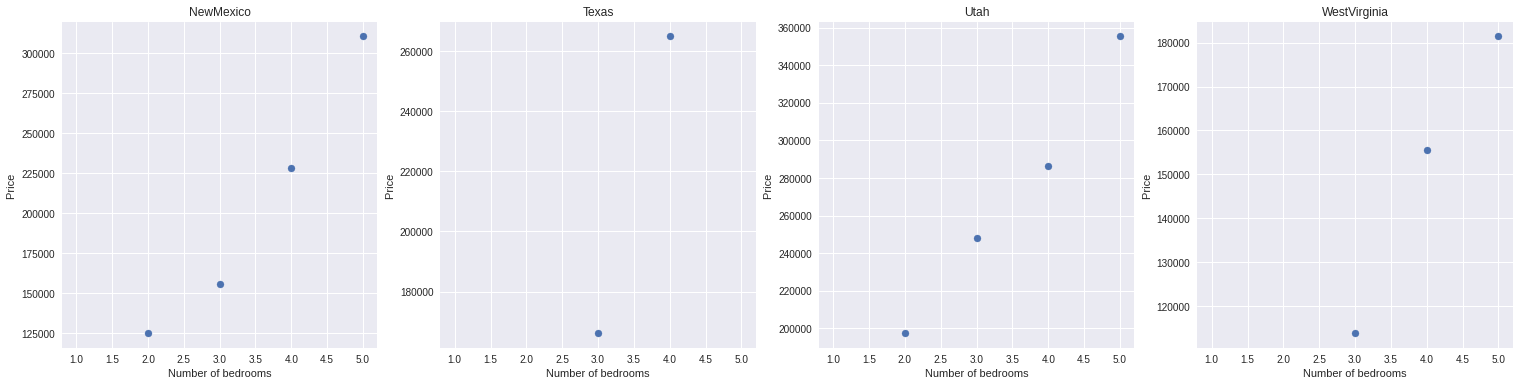

In [6]:
data_Nans=data_recent[(data_recent['RegionName']=='WestVirginia') | (data_recent['RegionName']=='Utah') | (data_recent['RegionName']=='Texas') | (data_recent['RegionName']=='NewMexico')]
states_interpolation=data_Nans['RegionName']
data_Nans=data_Nans.T.drop(['Date','RegionName','Price_SingleFamilyResidence'])
fig, ax=plt.subplots(1,4,figsize=(26,6))
for j in range(len(data_Nans.columns)):
  ax[j].scatter([1,2,3,4,5],data_Nans.iloc[:,j])
  ax[j].set(xlabel='Number of bedrooms',ylabel='Price ',title=states_interpolation.iloc[j])

* We can notice a clear linearity beween the price of the properties and the number of beedrooms they have.
* The only case where the relation seems to be a little bit quadratic is in the case of New Mexico but we will stick to the linear interpolation for the sake of simplicity.
* So we will use Linear Regression for the interpolation.


In [7]:
#Regression interpolation:
index_null=data_recent[data_recent.isnull().any(axis=1)].index #Index of the states with null values
for index in index_null:

  prices_for_different_houses=data_recent[data_recent.isnull().any(axis=1)].loc[index][2:7]
  
  x_train=np.array([1,2,3,4,5])[prices_for_different_houses.notnull()].reshape(-1,1)
  y_train=prices_for_different_houses.dropna().values.reshape(-1,1)
  
  regression=LinearRegression()
  regression=regression.fit(x_train,y_train)
  for type_home in data_recent.columns[2:7]:
    if(math.isnan(data_recent.loc[index,type_home])==True):
      data_recent.loc[index,type_home]=regression.predict(np.array(list(data_recent.columns[2:7]).index(type_home)+1).reshape(-1,1))[0][0] #it gives me the predictions in the form of a list inside on list

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in


After the interpolation we look at the linearity to check if everything went right:



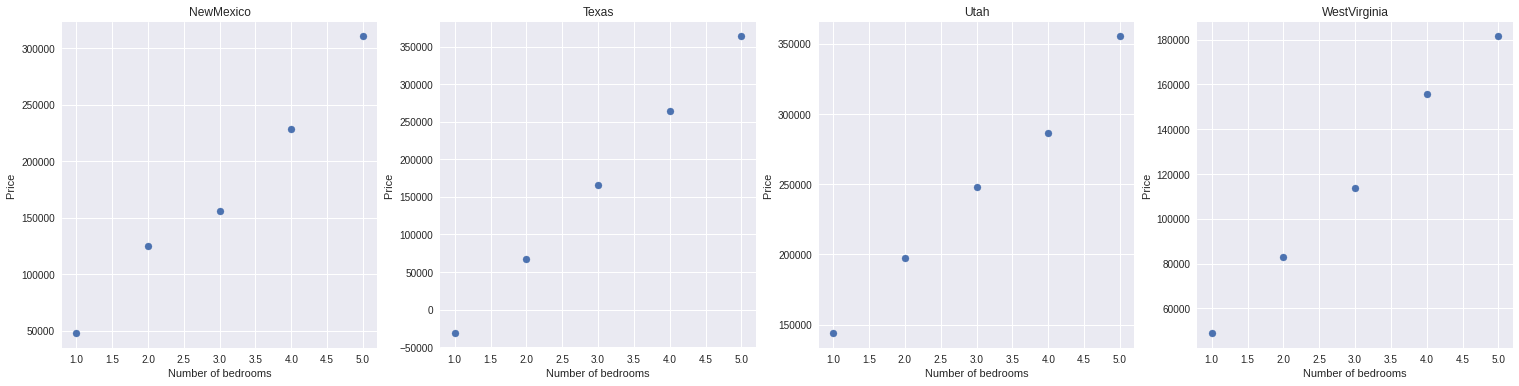

In [8]:
data_Nans=data_recent[(data_recent['RegionName']=='WestVirginia') | (data_recent['RegionName']=='Utah') | (data_recent['RegionName']=='Texas') | (data_recent['RegionName']=='NewMexico')]
states_interpolation=data_Nans['RegionName']
data_Nans=data_Nans.T.drop(['Date','RegionName','Price_SingleFamilyResidence'])
fig, ax=plt.subplots(1,4,figsize=(26,6))
for j in range(len(data_Nans.columns)):
  ax[j].scatter([1,2,3,4,5],data_Nans.iloc[:,j])
  ax[j].set(xlabel='Number of bedrooms',ylabel='Price ',title=states_interpolation.iloc[j])



*   Everything went as expected and the results are satisfactory.
*   The only problem we find is in the case of Texas. Because of the poor amount of information we hace about the state the linear model gives us even negative results for the price of 1 bedroom properties. The only option we have left is just to not consider Texas in the project and in a future when more data is available we can consider it back.



In [9]:
data_recent=data_recent.drop(13205,axis=0) #we eliminate texas
data_recent['mean']=0

In [10]:
for index in data_recent.index: #here we will calculate the mean of the 6 types of houses
  data_recent.loc[index,'mean']=data_recent.loc[index,'Price_1bedroom':'Price_SingleFamilyResidence'].mean()

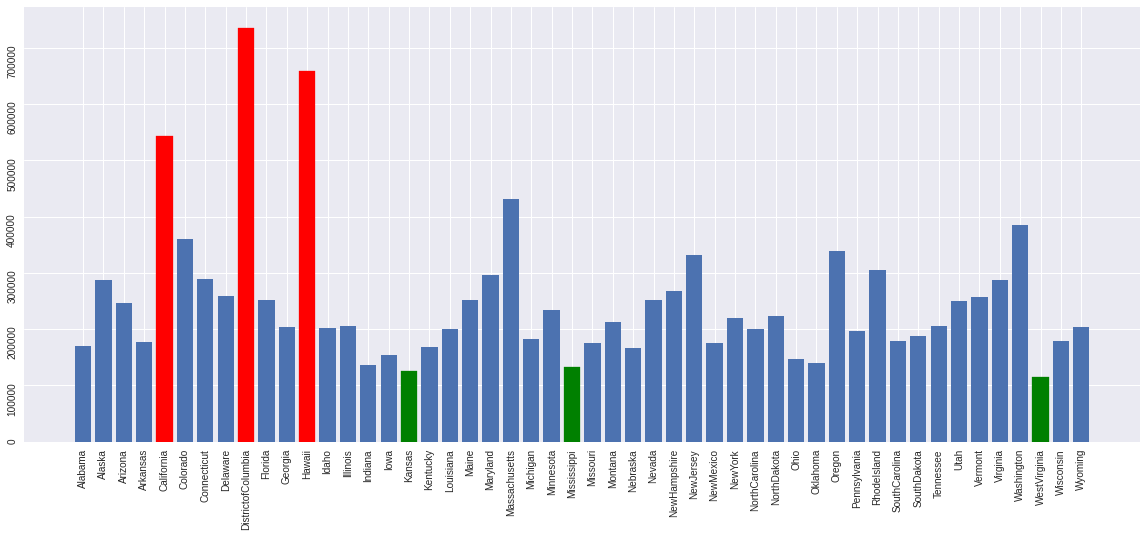

In [11]:
plt.figure(figsize=(20,8))
barlist=plt.bar(x='RegionName',height='mean',data=data_recent)
for i in [4,8,11]:
  barlist[i].set_color('r')

index_lows=[]
for state in ['WestVirginia','Kansas','Mississippi']:
  index_lows.append(list(data_recent['RegionName']).index(state))
for i in index_lows:
  barlist[i].set_color('g')

plt.tick_params(labelrotation=90)
plt.show()



*   The states with the hiher prices are the District of Columbia, Hawaii and California.
*   The lowest prices are in the states of West Virginia, Kansas and Mississippi. 



#Iowa
Let's take a more closer look to the prices in the state of Iowa.

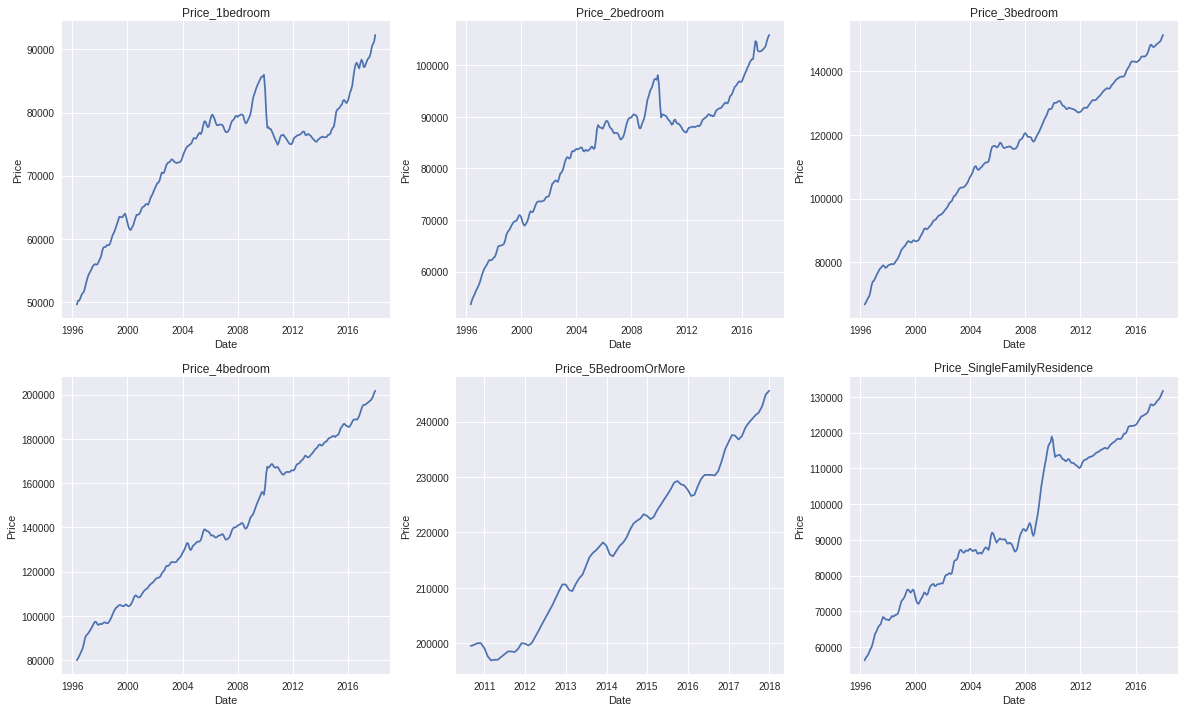

In [12]:
data_Iowa=data[data['RegionName']=='Iowa'].drop('RegionName',axis=1)
data_Iowa['Date']=pd.to_datetime(data_Iowa['Date'])
data_Iowa=data_Iowa.set_index('Date')

fig, ax=plt.subplots(2,3,figsize=(20,12))
for i in range(2):
  for j in range(3):
    if(i==0):
      ax[i,j].plot(data_Iowa.iloc[:,j])
      ax[i,j].set(xlabel='Date',ylabel='Price',title=house_types[j])
    if(i==1):
      ax[i,j].plot(data_Iowa.iloc[:,3+j])
      ax[i,j].set(xlabel='Date',ylabel='Price',title=house_types[3+j])  

* As we already said Iowa was not that affected by the burst of the bubble even with an increase of the price in some types of properties like 4-bedroom ones during the years that the prices plummeted in other states. That is the rerason of why we will be taking a closer look to this state.
* In the 6 types of houses we can dettect an obious **Additive Trend**
* In all the cases looking more closely we can detect **Seasonal** and **Irregular components**

#Smoothing
To remove the randomness we could use the MA(8) approach for all the different prices:



In [13]:
smoothed_data=data_Iowa.copy()

In [14]:
q=8
name_columns_smoothed=data_Iowa.columns+str(' Smoothed')
for i in range(len(name_columns_smoothed)):
  smoothed_data[name_columns_smoothed[i]]=smoothed_data.iloc[:,i].rolling(q, center=True).mean()

Let's check the smoothed data and the original one to see the difference in the 4 bedroom case for example:

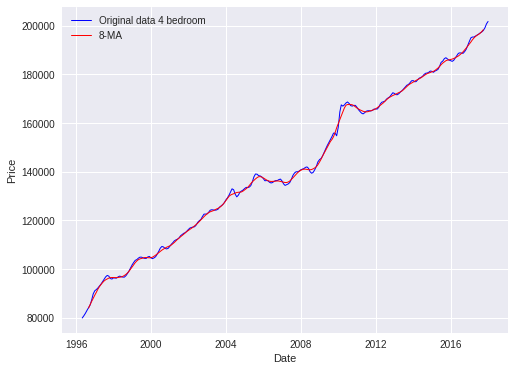

In [15]:
plt.figure(figsize=(8,6))
plt.plot(smoothed_data['Price_4bedroom'],'b-',label = 'Original data 4 bedroom', linewidth=1 )
plt.plot(smoothed_data['Price_4bedroom Smoothed'],'r-',label = '8-MA', linewidth=1)
plt.legend()
plt.xlabel('Date')
plt.ylabel('Price');

#Additive Decomposition
Another approach is to do a decomposition with the raw data and look at the different components in the 3 bedroom case for example:


Text(0.5, 1.0, 'Additive')

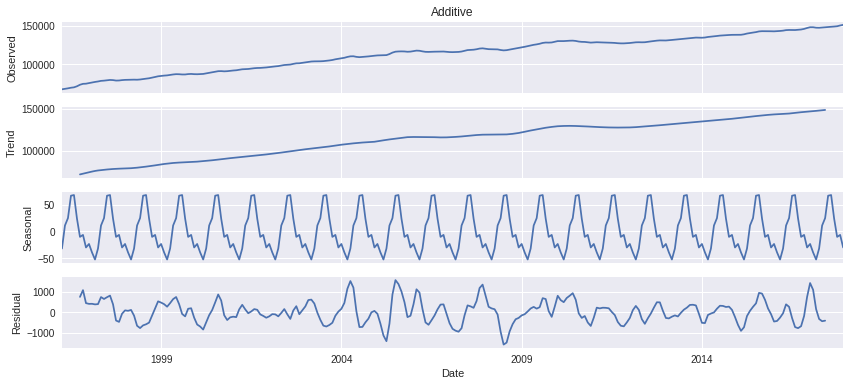

In [16]:
#Additive decomposition with the normal data
Price_3bedroom=data_Iowa['Price_3bedroom']
decompose_data_add = seasonal_decompose(Price_3bedroom, model='additive') # period 1 month

def plotseasonal(res, axes ):
    res.observed.plot(ax=axes[0], legend=False)
    axes[0].set_ylabel('Observed')
    res.trend.plot(ax=axes[1], legend=False)
    axes[1].set_ylabel('Trend')
    res.seasonal.plot(ax=axes[2], legend=False)
    axes[2].set_ylabel('Seasonal')
    res.resid.plot(ax=axes[3], legend=False)
    axes[3].set_ylabel('Residual')

fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(14,6))
plotseasonal(decompose_data_add, axes)
axes[0].set_title('Additive')

*   We can see a clear growing trend
*   The noise is not very significant too, with values that go from -1000 to 1000
*   The Seasonal trend is present but is not very signifficant (+-50). This is caused because we are looking at periods of 1 month. Let's explore what happens if we group the data in periods of 3 months(trimestrally):



Text(0.5, 1.0, 'Additive')

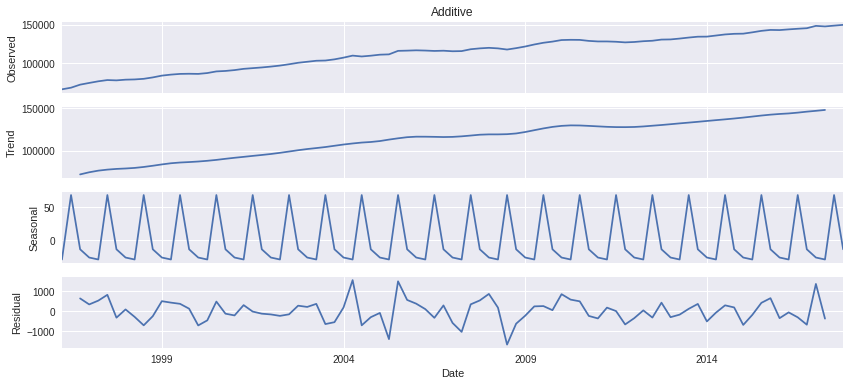

In [17]:
#Additive decomposition trimestraly data
trim_data_Price_3bedroom=data_Iowa['Price_3bedroom'].resample('3M').asfreq().dropna()
decompose_data_add = seasonal_decompose(trim_data_Price_3bedroom, model='additive')
fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(14,6))
plotseasonal(decompose_data_add, axes)
axes[0].set_title('Additive')

*   In this case we get a seasonal trend of arround 60
* The other components are similar




#Forecasting with Holt-Winters method
We will try the method with additive trend and multiplicative trend and see what gives us better results

In [18]:
n=48
train=data_Iowa['Price_3bedroom'][:-n]
test=data_Iowa['Price_3bedroom'][-n:] #We will do the testing with the last 2 years of data

model_Exp_add=ExponentialSmoothing(train, seasonal_periods=12, trend='add', seasonal='add').fit()
predictions_Exp_add=model_Exp_add.forecast(n)

model_Exp_mul=ExponentialSmoothing(train, seasonal_periods=12, trend='mul', seasonal='add').fit()
predictions_Exp_mul=model_Exp_mul.forecast(n)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


##Evaluating model performance:

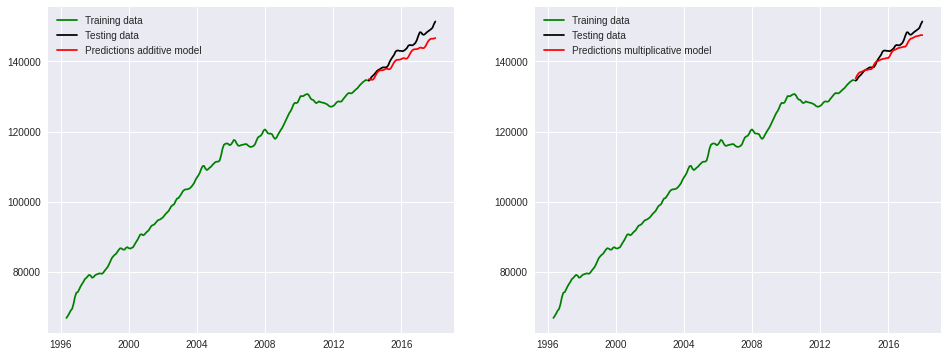

In [19]:
#Performance of the additive:
rmse_add = mean_squared_error(test, predictions_Exp_add, squared=False)
mae_add = mean_absolute_error(test, predictions_Exp_add)

rmse_mul = mean_squared_error(test, predictions_Exp_mul, squared=False)
mae_mul = mean_absolute_error(test, predictions_Exp_mul)

fi, ax=plt.subplots(1,2,figsize=(16,6))
ax[0].plot(train, color='green',label='Training data')
ax[0].plot(test, color='black', label='Testing data')
ax[0].plot(predictions_Exp_add, color='red', label='Predictions additive model')
ax[0].legend()

ax[1].plot(train, color='green',label='Training data')
ax[1].plot(test, color='black', label='Testing data')
ax[1].plot(predictions_Exp_mul, color='red', label='Predictions multiplicative model')
ax[1].legend()



*   The multiplicative model seems to have better results than the additive model
*   Let's take a look into the RMSE and MAE values:







In [20]:
performance_models=pd.DataFrame({'Model':['Additive','Multiplicative'],'RMSE':[rmse_add,rmse_mul],'MAE':[mae_add,mae_mul]})
performance_models=performance_models.set_index('Model')
performance_models

RMSE          MAE
Model                                   
Additive        2486.890129  2154.525031
Multiplicative  1592.597222  1296.344984



*   We can see that in both evaluations the multiplicative model is more aaccurate.



#Autoregressive and Moving Average Models Forecasting

* To apply this models first we have to make our data stationary so we will use the differentiating model:

ADF Statistic       p-value
Test                                       
ADF (AIC) test      -5.483495  2.256791e-06
ADF (BIC) test      -5.906895  2.695349e-07

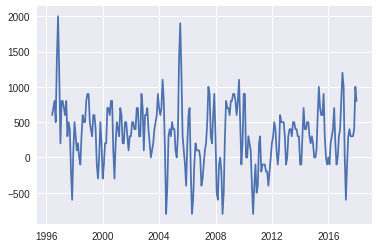

In [34]:
from statsmodels.tsa.stattools import adfuller

Serie=data_Iowa['Price_3bedroom']
Serie_diff_o1=Serie.diff().dropna()

plt.plot(Serie_diff_o1)

adf_test_AIC=adfuller(Serie_diff_o1,autolag='AIC')
adf_test_BIC=adfuller(Serie_diff_o1,autolag='BIC')

test_results=pd.DataFrame({'Test':['ADF (AIC) test','ADF (BIC) test'],'ADF Statistic':[adf_test_AIC[0],adf_test_BIC[0]],'p-value':[adf_test_AIC[1],adf_test_BIC[1]]})
test_results=test_results.set_index('Test')
test_results



*   In both cases we get p-values smaller than 0.05 in the Augmented Dickey-Fuller test so we can conlude that the differentiated data is indeed stationary




In [27]:
#pip install statsmodels

In [29]:
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.regression.linear_model import yule_walker

* Let's check what model will fit better our data using the PACF and ACF plots:

Text(0.5, 0.98, 'ACF-PACF for the Sattionary data process')

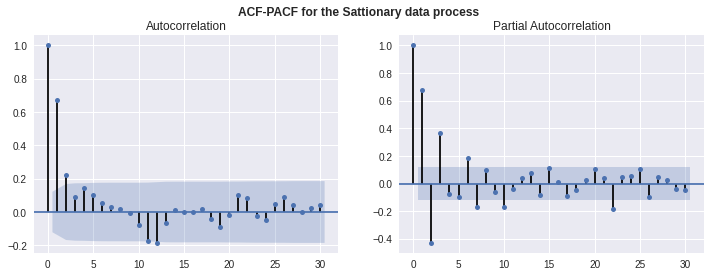

In [30]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
plot_acf(Serie_diff_o1, lags=30, ax=ax[0])
plot_pacf(Serie_diff_o1, lags=30, ax=ax[1])
plt.suptitle('ACF-PACF for the Sattionary data process', weight='bold')

* We can see that the ACF has suddent drop after the 2nd lag and converges to zero.
* In the PACF we could say that the data slowly converges to zero.
* Our best guess then will be to fit a ARMA model to the data and evaluate the pertformances of both models. We will use the parameters (p=4,q=2) and (p=4,q=3) and see wich one works better


In [77]:
n=48
train=Serie_diff_o1[:-n]
test=Serie_diff_o1[-n:]

model_ARIMA42=ARIMA(train, order=(4,0,2))
model_ARIMA42=model_ARIMA42.fit()
prediction_ARIMA42=model_ARIMA42.predict(start=len(Serie_diff_o1)-48,end=len(Serie_diff_o1))

model_ARIMA43=ARIMA(train, order=(4,0,3))
model_ARIMA43=model_ARIMA43.fit()
prediction_ARIMA43=model_ARIMA43.predict(start=len(Serie_diff_o1)-48,end=len(Serie_diff_o1))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


##Evaluation of the models

'rmse_add = mean_squared_error(, predictions_Exp_add, squared=False)\nmae_add = mean_absolute_error(test, predictions_Exp_add)\n\nrmse_mul = mean_squared_error(test, predictions_Exp_mul, squared=False)\nmae_mul = mean_absolute_error(test, predictions_Exp_mul)'

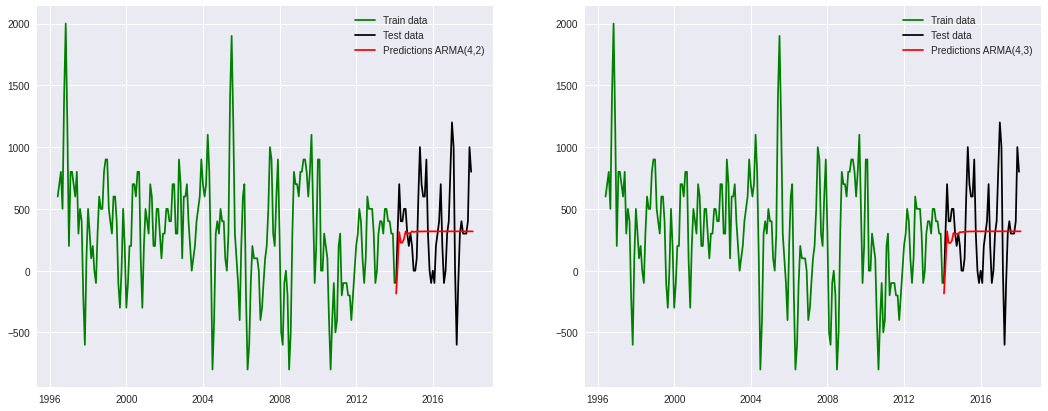

In [78]:
fig, ax=plt.subplots(1,2,figsize=(18,7))
ax[0].plot(train, color='green',label='Train data')
ax[0].plot(test, color='black',label='Test data')
ax[0].plot(prediction_ARIMA42, color='red', label='Predictions ARMA(4,2)')
ax[0].legend()

ax[1].plot(train, color='green',label='Train data')
ax[1].plot(test, color='black',label='Test data')
ax[1].plot(prediction_ARIMA43, color='red', label='Predictions ARMA(4,3)')
ax[1].legend()



*   As we can visualy see the models completelly fail to fit the data, so we will not use them.



#Frequency Analyisis
Let's now do Frequency analaysis in the differentiated data and calculate the Periodogram of the series to approximate the Power Spectral Density:

Total sum Spectrum: 293769.23076923075
Total sum Density: 763800.0000000001


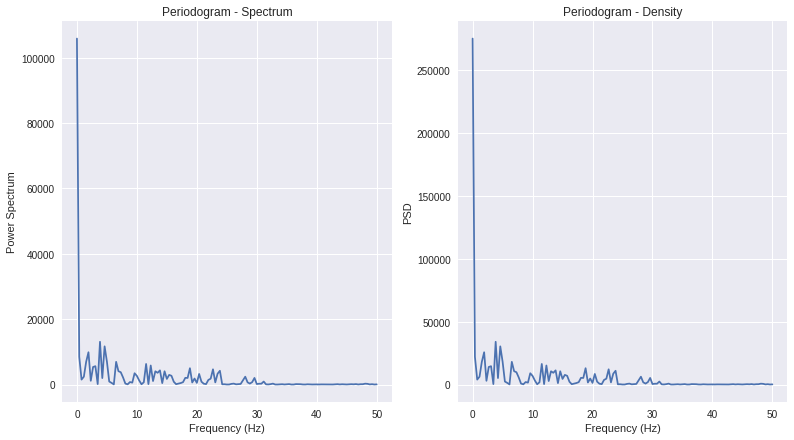

In [80]:
from scipy import stats,signal
Fs=100
f_per_spect, Pxx_per_spect = signal.periodogram(Serie_diff_o1,Fs,detrend=False,window=None,nfft=None,return_onesided=True,scaling='spectrum')
f_per_density, Pxx_per_density = signal.periodogram(Serie_diff_o1,Fs,detrend=False,window=None,nfft=None,return_onesided=True,scaling='density')

fig1, ax = plt.subplots(1,2,figsize=(13, 7)) 
ax[0].plot(f_per_spect, Pxx_per_spect)      
ax[0].set_title('Periodogram - Spectrum')
ax[0].set(xlabel='Frequency (Hz)', ylabel='Power Spectrum');


ax[1].plot(f_per_density, Pxx_per_density)      
ax[1].set_title('Periodogram - Density')
ax[1].set(xlabel='Frequency (Hz)', ylabel='PSD');

print('Total sum Spectrum:', Pxx_per_spect.sum())
print('Total sum Density:', Pxx_per_density.sum())


* We can see there is a possible seasonal
pattern over a range of 5-6 months
* There are other frequencies quite small so we will not consider them

#Brief conclusions of the project



1.   First we want to note that we had to do forecasting with the prices of a state like Iowa because of the affect of the explosion of the bubble that affected so much other states.
2.   Maybe if we continue getting data in the future and this data contains another fonomena like the explosion of the bubble be could extract this cyclic component to predict future bubbles.
3. Regarding the exploration we concluded that the cheapest states to buy a property are West Virginia, Kansas and Mississipi.
4. The most expensive states to live in are District of Columbia, Hawaii and California.
5. Since the District of Columbia is just a city and not properly a state we should not consider this result as significant.
6. About predictive models the Holt-Winters with multiplicative trend shows the best results in the test data.
7. In the other hand the ARIMA models that we implemented completely fail to fit the differenciated stationary data.



